# EDA
In this notebook we analyse the dataset that we have now normalized in the previous Data Processing notebook. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('df_cleaned.csv')
df_cancel = pd.read_csv('df_cancel.csv')

## Correlational heatmap
Firstly let's create a heatmap between the delay factors.

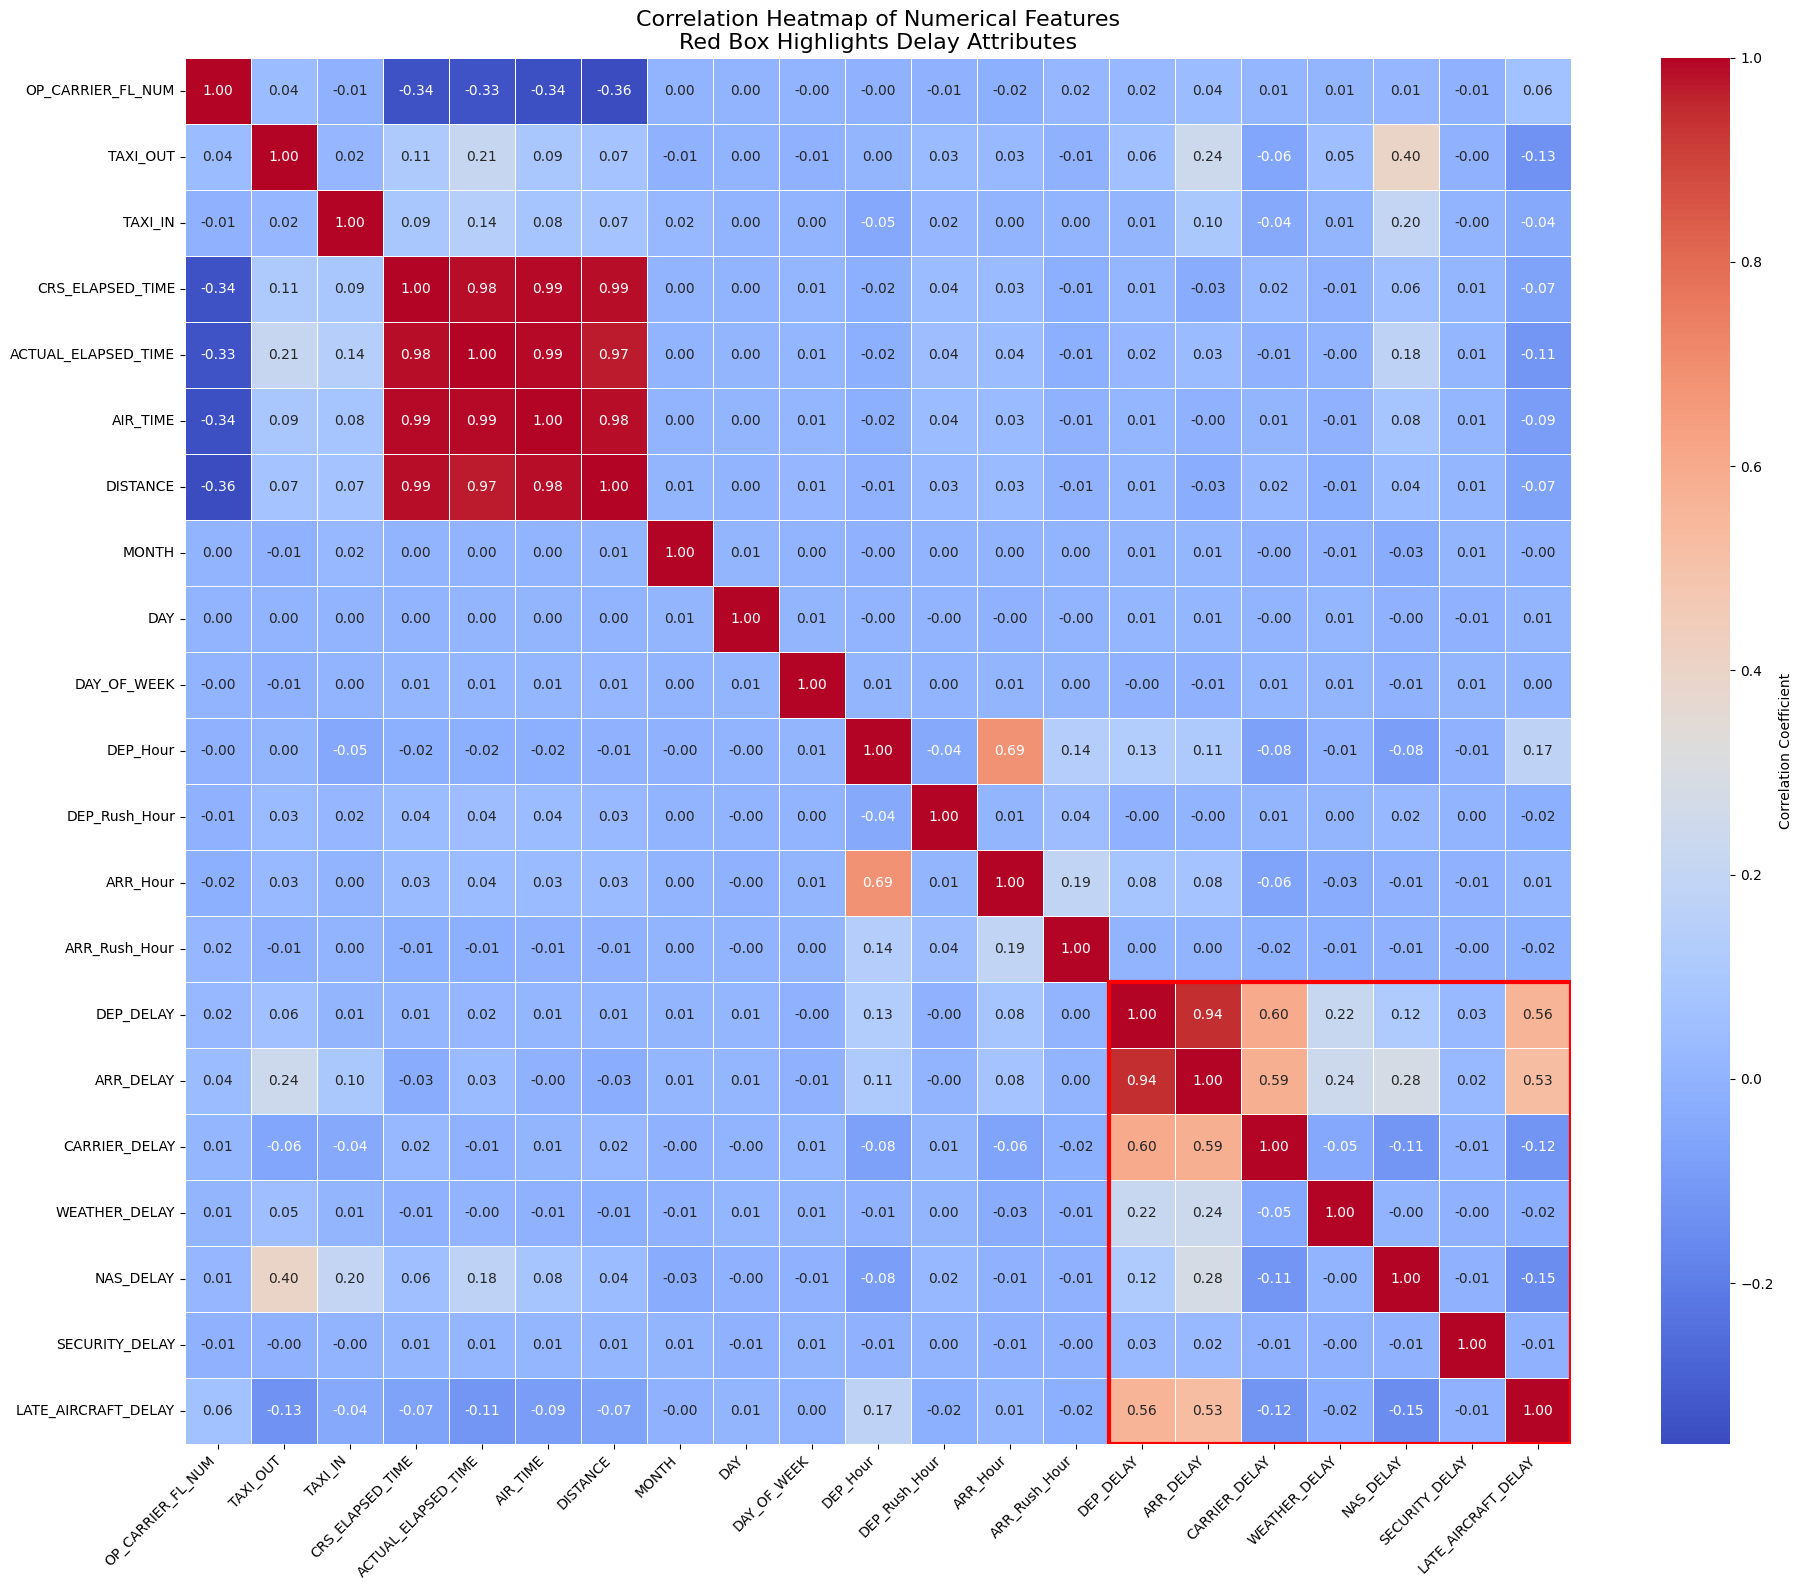


Detailed Delay Attributes Correlation:
                     DEP_DELAY  ARR_DELAY  CARRIER_DELAY  WEATHER_DELAY  \
DEP_DELAY             1.000000   0.943565       0.599600       0.216644   
ARR_DELAY             0.943565   1.000000       0.586183       0.237862   
CARRIER_DELAY         0.599600   0.586183       1.000000      -0.045391   
WEATHER_DELAY         0.216644   0.237862      -0.045391       1.000000   
NAS_DELAY             0.118713   0.280010      -0.114209      -0.000751   
SECURITY_DELAY        0.025990   0.024718      -0.010288      -0.004008   
LATE_AIRCRAFT_DELAY   0.564872   0.528156      -0.121655      -0.023464   

                     NAS_DELAY  SECURITY_DELAY  LATE_AIRCRAFT_DELAY  
DEP_DELAY             0.118713        0.025990             0.564872  
ARR_DELAY             0.280010        0.024718             0.528156  
CARRIER_DELAY        -0.114209       -0.010288            -0.121655  
WEATHER_DELAY        -0.000751       -0.004008            -0.023464  
NAS_DELAY

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define delay-related columns
delay_columns = ['DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 
                 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 
                 'LATE_AIRCRAFT_DELAY']

# Select all numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

numerical_cols = numerical_cols.drop('YEAR', errors='ignore')
# Separate non-delay columns
non_delay_columns = [col for col in numerical_cols if col not in delay_columns]

# Reorder columns to group delay attributes together
reordered_columns = non_delay_columns + delay_columns

# Compute correlation matrix with reordered columns
corr_matrix = df[reordered_columns].corr()

# Create the plot
plt.figure(figsize=(20, 16))

# Create the heatmap
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=0.5,
            square=True,
            cbar_kws={'label': 'Correlation Coefficient'})

# Find the start index of delay columns
delay_start_index = len(non_delay_columns)

# Draw a rectangle around delay columns
plt.gca().add_patch(plt.Rectangle(
    (delay_start_index, delay_start_index), 
    len(delay_columns), 
    len(delay_columns), 
    fill=False, 
    edgecolor='red', 
    lw=3
))

plt.title('Correlation Heatmap of Numerical Features\nRed Box Highlights Delay Attributes', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


delay_corr = corr_matrix.loc[delay_columns, delay_columns]
# Print out detailed delay correlations
print("\nDetailed Delay Attributes Correlation:")
print(delay_corr)

# Identify strongest correlations among delay attributes
def find_top_correlations(corr_matrix, n=5):
    # Create a mask to avoid duplicates and self-correlations
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Flatten the correlation matrix
    corr_flat = corr_matrix.where(~mask).stack().reset_index()
    corr_flat.columns = ['Feature 1', 'Feature 2', 'Correlation']
    
    # Sort by absolute correlation value
    top_correlations = corr_flat.reindex(
        corr_flat['Correlation'].abs().sort_values(ascending=False).index
    )
    
    return top_correlations.head(n)

print("\nTop 5 Correlations among Delay Attributes:")
print(find_top_correlations(delay_corr))

Looking at the heatmap we can see the correlations between the delay factors.
- DEP_DELAY and ARR_DELAY have high correlation. This is expected, as delayed departure results in a delayed arrival.
- DEP_DELAY and CARRIER_DELAY have a medium correlation, which means delays caused by the airline are somewhat related to departure delays.
- WEATHER_DELAY has low correlation to other factors, which means weather isn't a big cause of delays.
- LATE_AIRCRAFT_DELAY has medium correlation to DEP_DELAY and ARR_DELAY, which means aircraft delays contribute significantly to delays in departures and arrivals.
- NAS_DELAY has low correlations to other factors, which means it doesn't affect delays that much.
- Correlation with SECURITY_DELAY is minimal, as is the number of delays caused by security reasons.

## Delay analsyis

### Histogram of delays

Now let's create histograms for some simple delay analysi:

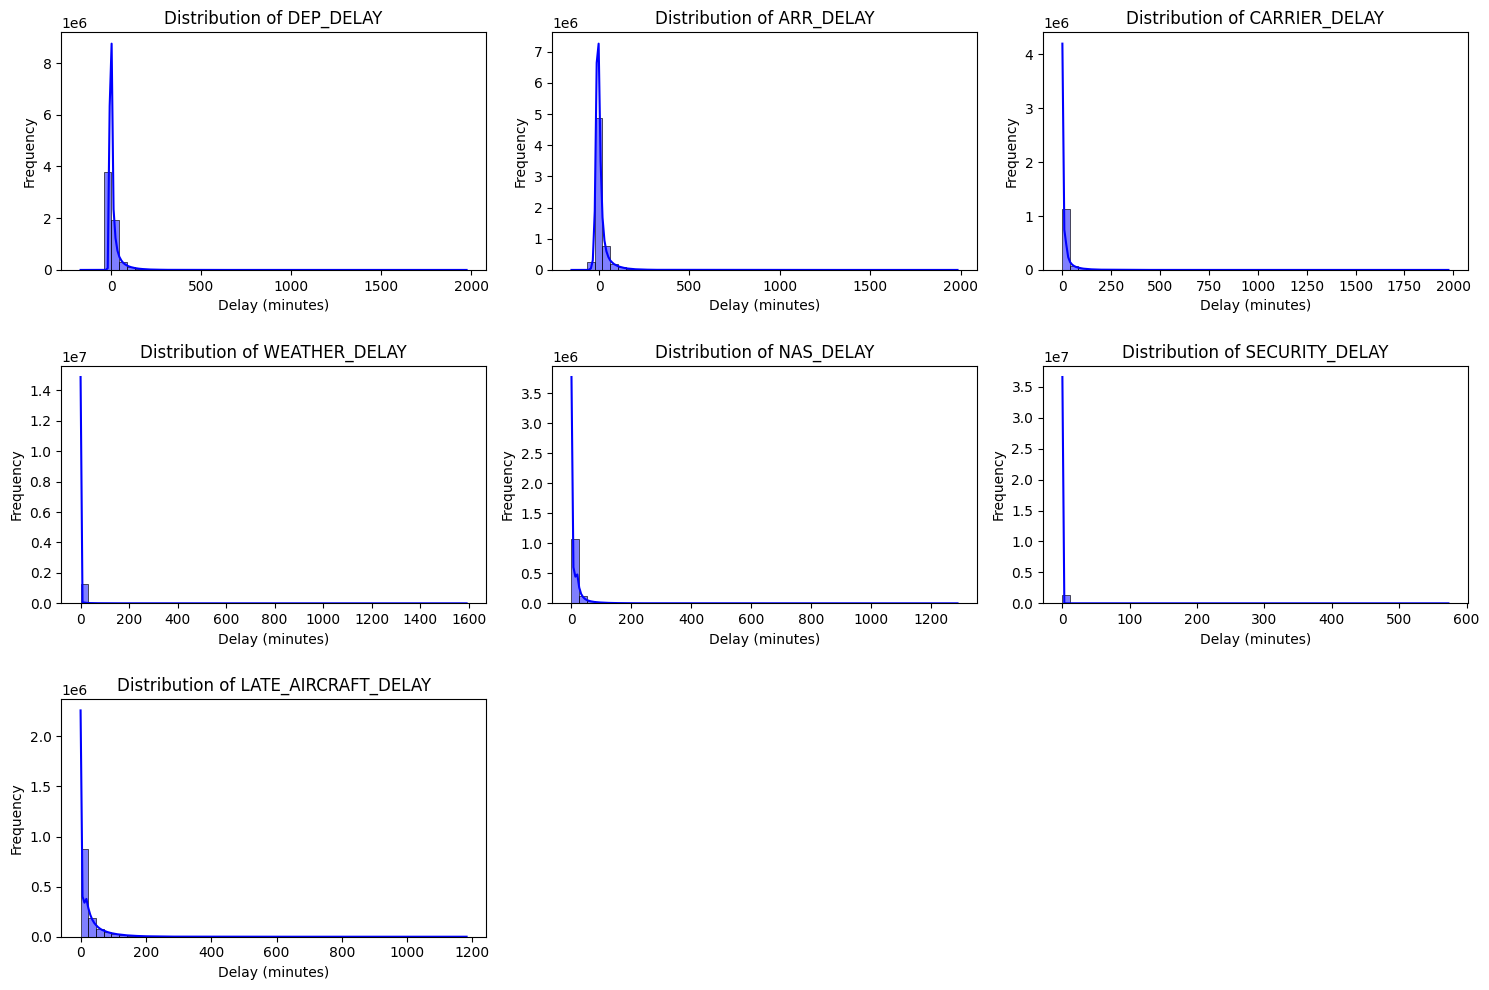

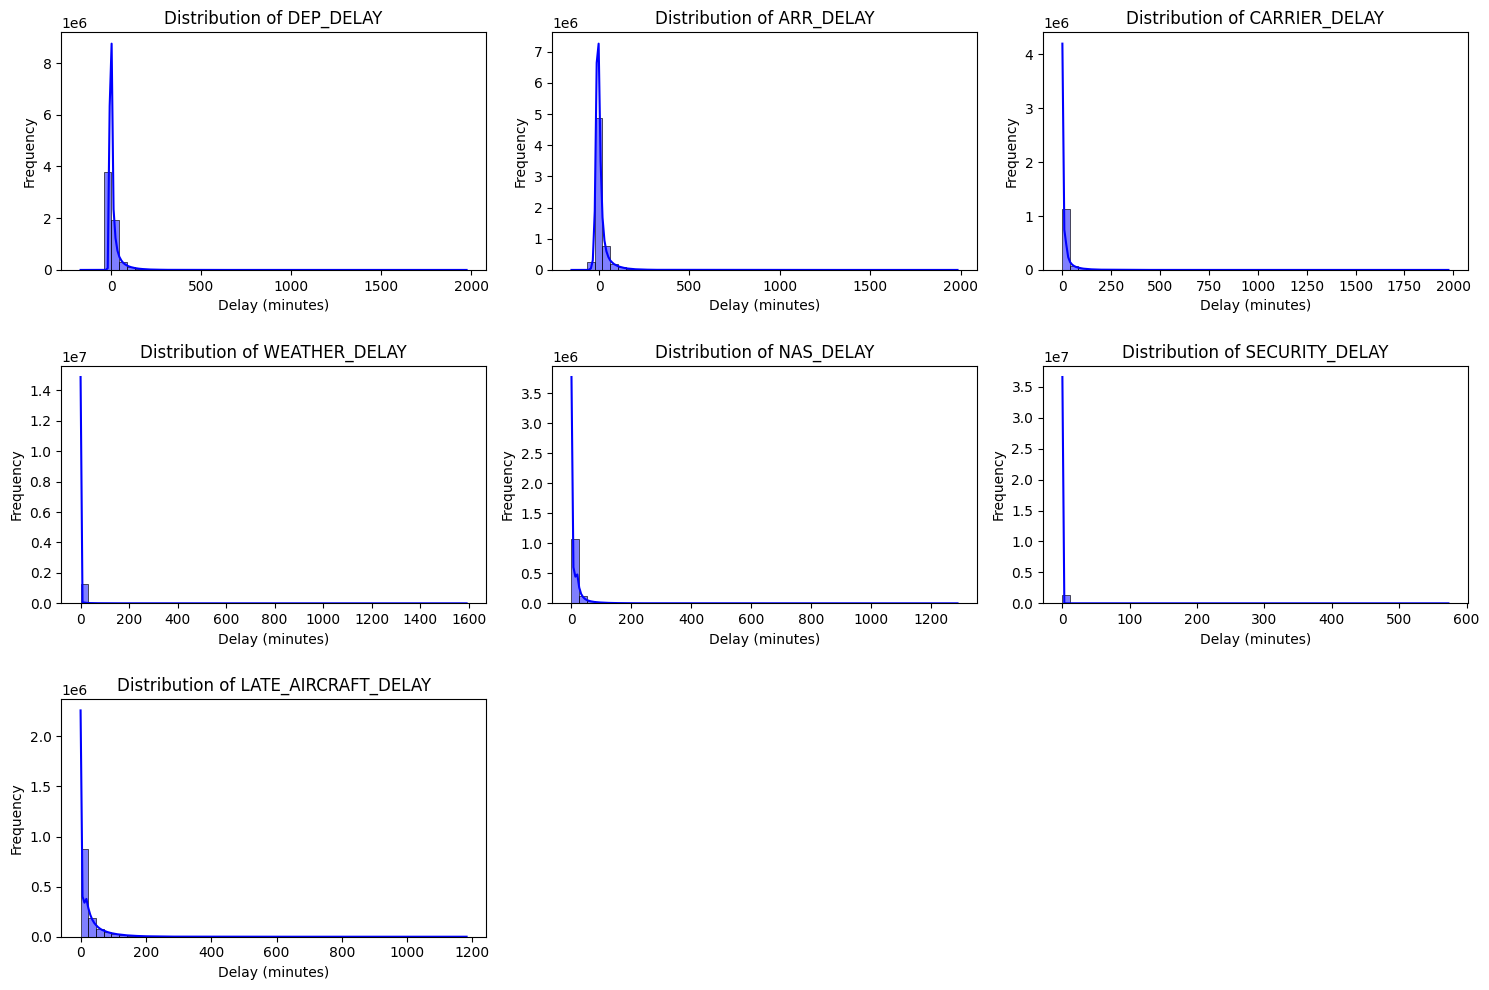

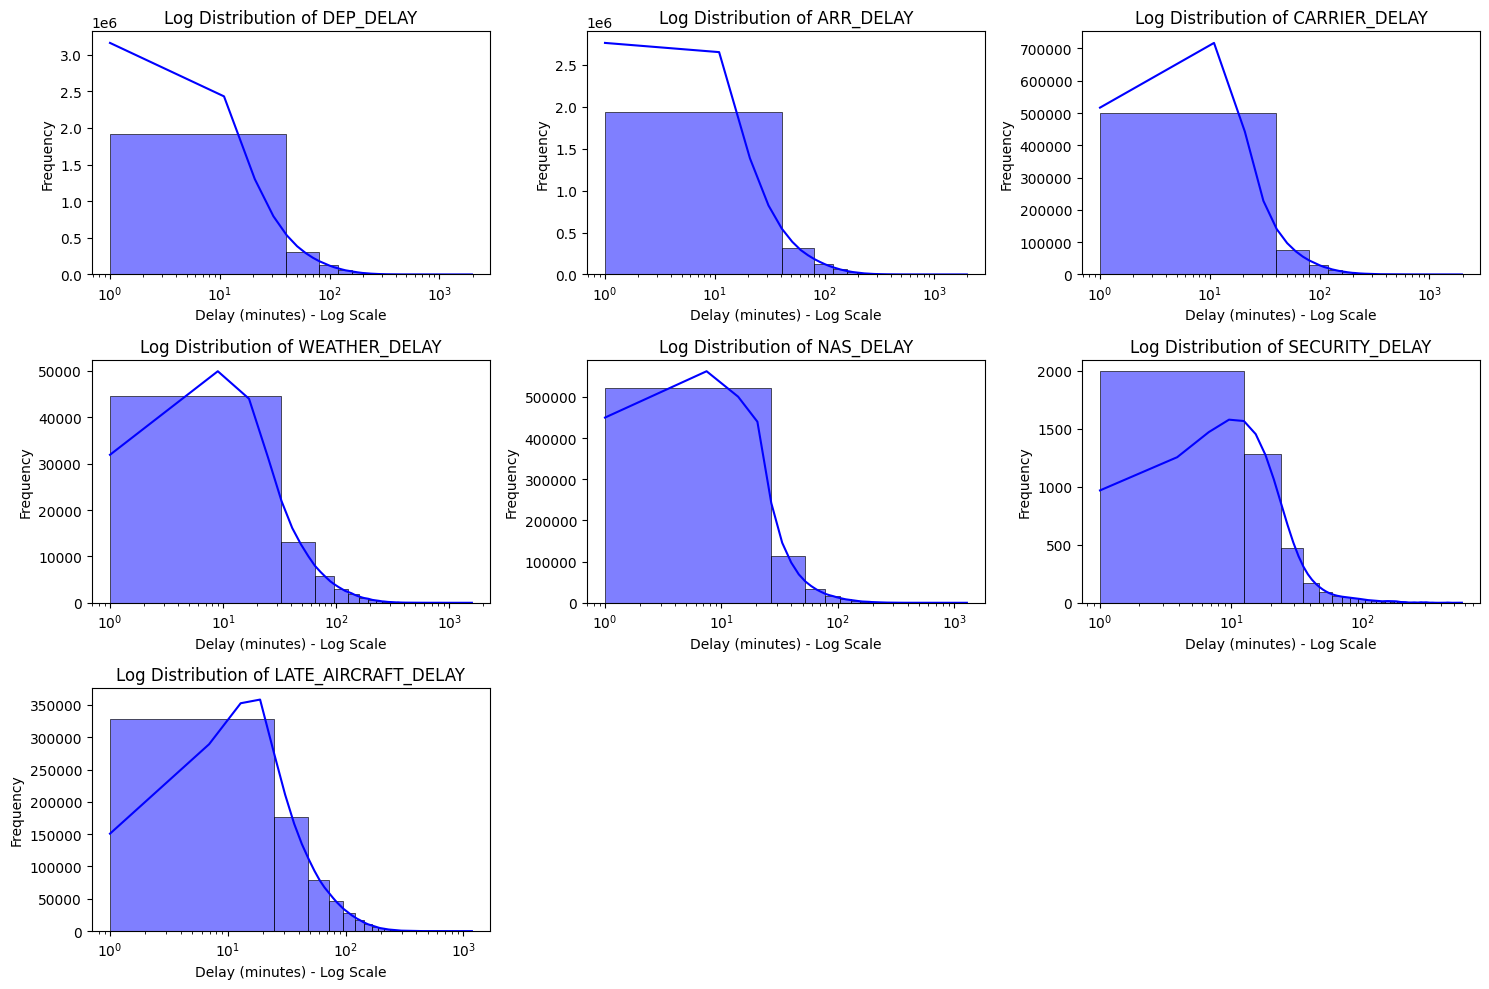

                          mean  median        std     max    min  \
DEP_DELAY             9.684819    -1.0  35.567039  1975.0 -171.0   
ARR_DELAY             6.010872    -3.0  38.052002  1983.0 -153.0   
CARRIER_DELAY        16.652706     1.0  43.581631  1975.0    0.0   
WEATHER_DELAY         2.343187     0.0  17.025016  1591.0    0.0   
NAS_DELAY            13.729758     3.0  27.654010  1287.0    0.0   
SECURITY_DELAY        0.081661     0.0   2.627572   573.0    0.0   
LATE_AIRCRAFT_DELAY  23.868734     7.0  41.037532  1182.0    0.0   

                     zero_percentage  
DEP_DELAY                   5.632969  
ARR_DELAY                   2.414659  
CARRIER_DELAY              10.070567  
WEATHER_DELAY              19.141295  
NAS_DELAY                   8.967171  
SECURITY_DELAY             20.208713  
LATE_AIRCRAFT_DELAY         8.985959  


In [3]:


plt.figure(figsize=(15, 10))

# Calculate the number of rows and columns
num_cols = 3
num_rows = (len(delay_columns) + num_cols - 1) // num_cols

for i, col in enumerate(delay_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[col], bins=50, kde=True, color='blue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Delay (minutes)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Alternative approach with more flexibility
def plot_delay_distributions(data, columns, figsize=(15, 10), bins=50):
    num_cols = 3
    num_rows = (len(columns) + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the array of axes for easy indexing

    for i, col in enumerate(columns):
        sns.histplot(data[col], bins=bins, kde=True, color='blue', edgecolor='black', ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel('Delay (minutes)')
        axes[i].set_ylabel('Frequency')

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Use the function
plot_delay_distributions(df, delay_columns)

# Optional: Log scale version
def plot_delay_distributions_log(data, columns, figsize=(15, 10), bins=50):
    num_cols = 3
    num_rows = (len(columns) + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the array of axes for easy indexing

    for i, col in enumerate(columns):
        # Filter out zero and negative values for log scale
        positive_data = data[data[col] > 0][col]
        
        sns.histplot(positive_data, bins=bins, kde=True, color='blue', edgecolor='black', ax=axes[i])
        axes[i].set_xscale('log')
        axes[i].set_title(f'Log Distribution of {col}')
        axes[i].set_xlabel('Delay (minutes) - Log Scale')
        axes[i].set_ylabel('Frequency')

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Use the log scale version
plot_delay_distributions_log(df, delay_columns)

# Additional statistical summary
def delay_distribution_summary(data, columns):
    summary = {}
    for col in columns:
        summary[col] = {
            'mean': data[col].mean(),
            'median': data[col].median(),
            'std': data[col].std(),
            'max': data[col].max(),
            'min': data[col].min(),
            'zero_percentage': (data[col] == 0).mean() * 100
        }
    
    return pd.DataFrame.from_dict(summary, orient='index')

# Print summary
print(delay_distribution_summary(df, delay_columns))

Histograms show distributions of various types of delays, with most of them being around the lower end of the scale, which means most of the delays are somewhat short, but some delays are absurdly long, which seems odd.

Now let's get into delay factors breakdown by categorical variables.

### Breakdown of delays by carrier

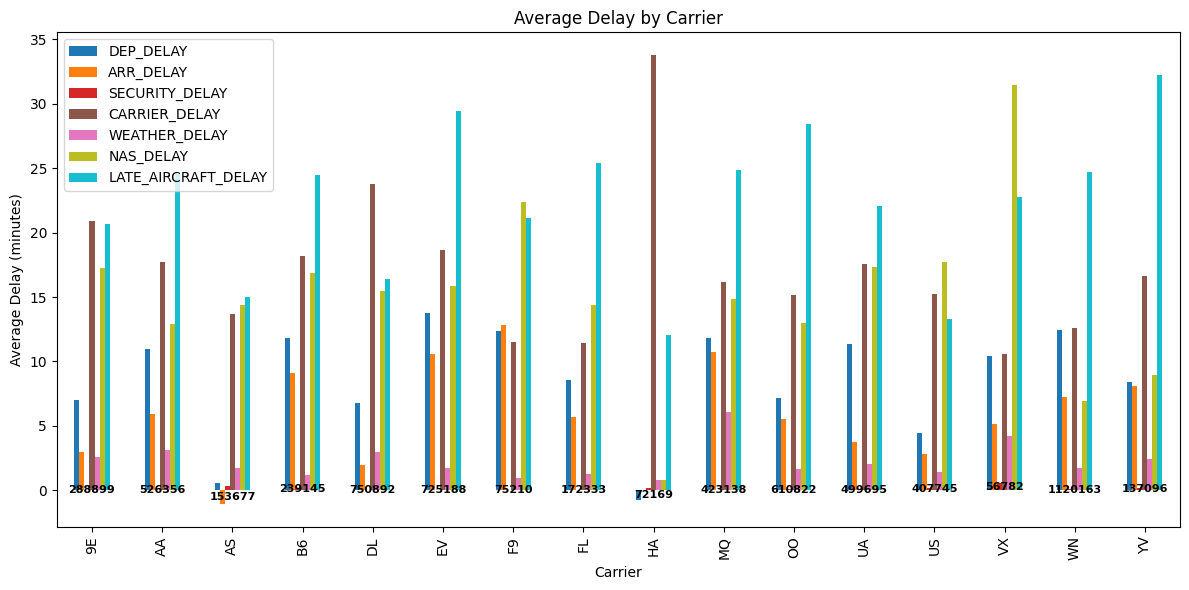

In [4]:
# Calculate mean delays

carrier_delay = df.groupby('OP_CARRIER')[['DEP_DELAY', 'ARR_DELAY', 'SECURITY_DELAY' ,  'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY']].mean()

# Calculate counts for each carrier
carrier_counts = df.groupby('OP_CARRIER').size()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars

carrier_delay.plot(kind='bar', ax=ax,colormap='tab10')




for i, carrier in enumerate(carrier_delay.index):
    # Get the height of the first bar in the group
    bar_height = carrier_delay.iloc[i].min()
    
    plt.text(i, bar_height/2, f'{carrier_counts[carrier]}', 
             horizontalalignment='center', 
             verticalalignment='center',
             color='black',
             fontweight='bold',
             fontsize=8)

plt.title('Average Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Average Delay (minutes)')
plt.tight_layout()
plt.show()

We can see that across the board, the biggest causers of delays are still the aircraft delay and delays caused by the carrier. The least relevant causer of delay is by far security reasons. Delays caused by the weather or by meteorogical institutes (NAS) are also rather sizeable.

Next, let's look at the average departure delay by the top 30 and bottom 30 airports. We aren't using all of the airports, because there are way too many of them.

### Breakdown of delays by departure airport

C:\Users\Kaarel\AppData\Local\Temp\ipykernel_29688\794591286.py:58: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', pad=0.02, shrink=0.8)


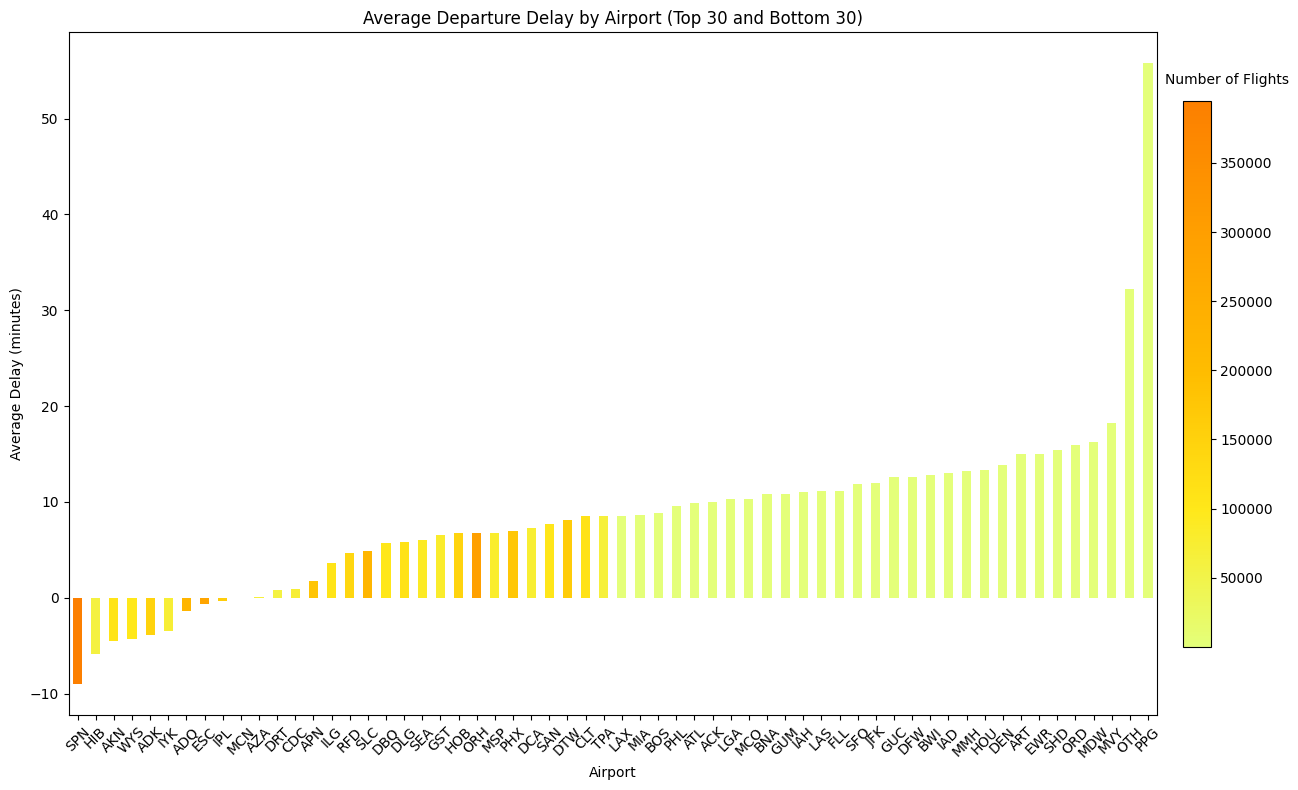

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and it has been defined earlier

# Count flights per airport
airport_flight_counts = df['ORIGIN'].value_counts()

# Get top and bottom 30 airports
top_30_airports = airport_flight_counts.head(30).index
bottom_30_airports = airport_flight_counts.tail(30).index
top_30_data = df[df['ORIGIN'].isin(top_30_airports)]
bottom_30_data = df[df['ORIGIN'].isin(bottom_30_airports)]
top_30_delay = top_30_data.groupby('ORIGIN')['DEP_DELAY'].mean()
bottom_30_delay = bottom_30_data.groupby('ORIGIN')['DEP_DELAY'].mean()

# Combine delays
airport_delay = pd.concat([top_30_delay, bottom_30_delay])

# Normalize flight counts for coloring
flight_counts = airport_flight_counts[airport_delay.index]
norm_counts = (flight_counts - flight_counts.min()) / (flight_counts.max() - flight_counts.min())

# Create a colormap
cmap = plt.get_cmap('Wistia')
colors = cmap(norm_counts)

# Plot the average departure delays for top 30 and bottom 30 airports
plt.figure(figsize=(14, 8))
bars = airport_delay.sort_values().plot(kind='bar', color=colors)

# Add counts inside the bars
'''
for i, airport in enumerate(airport_delay.index):
    # Get the height of the bar
    bar_height = airport_delay.iloc[i]

    # Get the flight count for this airport
    count = airport_flight_counts[airport]

    # Adjust position based on bar height
    vertical_position = bar_height + 1  # Adjust to be above the bar
    plt.text(i, vertical_position, f'{count}', 
             horizontalalignment='center', 
             verticalalignment='bottom',
             rotation=0,  # Rotate text vertically
             color='black',  # Text color
             fontweight='bold',
             fontsize=5)
'''

# Add color gradient legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=flight_counts.min(), vmax=flight_counts.max()))
sm.set_array([])  # Only needed for older versions of matplotlib

# Change the location of the colorbar and scale it
cbar = plt.colorbar(sm, orientation='vertical', pad=0.02, shrink=0.8)

# Manually add a horizontal label above the colorbar
# Get the position of the colorbar
cbar_position = cbar.ax.get_position()  # Get the position of the colorbar

# Calculate the position for the text
text_x = cbar_position.x0 + (cbar_position.width / 2) + 62.5  # Centered above the colorbar
text_y = cbar_position.y1 + 0.02 + 52.5  # Slightly above the colorbar

# Use plt.text to place the label
plt.text(text_x, text_y, 'Number of Flights', fontsize=10, ha='center', va='bottom')

plt.title('Average Departure Delay by Airport (Top 30 and Bottom 30)')
plt.xlabel('Airport')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Looking at the plot, we can see that the largest delays are present in the airports with the least departures. The average delay is quite consistent for airports that have frequent/many departures.

### Breakdown of delays by arrival airport

C:\Users\Kaarel\AppData\Local\Temp\ipykernel_29688\1146854380.py:58: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', pad=0.02, shrink=0.8)


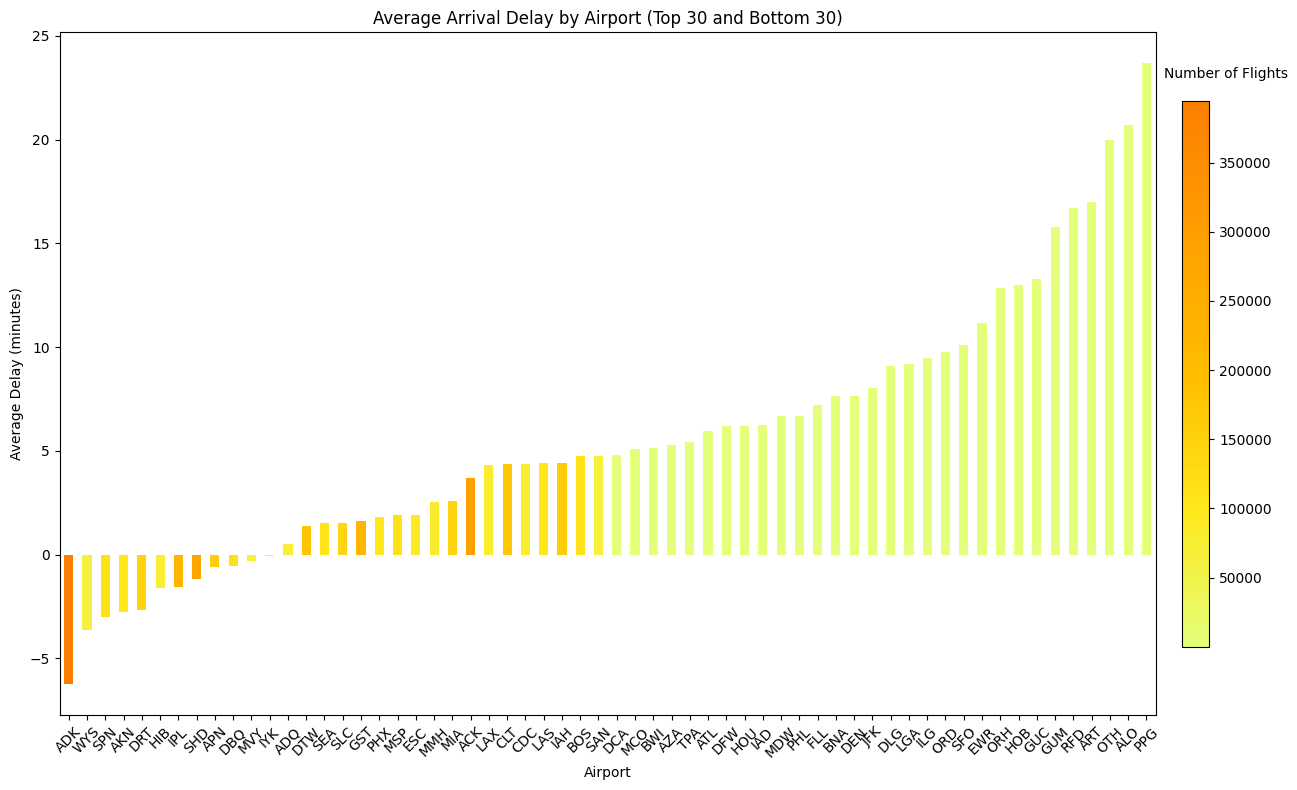

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and it has been defined earlier

# Count flights per airport
airport_flight_counts = df['DEST'].value_counts()

# Get top and bottom 30 airports
top_30_airports = airport_flight_counts.head(30).index
bottom_30_airports = airport_flight_counts.tail(30).index
top_30_data = df[df['DEST'].isin(top_30_airports)]
bottom_30_data = df[df['DEST'].isin(bottom_30_airports)]
top_30_delay = top_30_data.groupby('DEST')['ARR_DELAY'].mean()
bottom_30_delay = bottom_30_data.groupby('DEST')['ARR_DELAY'].mean()

# Combine delays
airport_delay = pd.concat([top_30_delay, bottom_30_delay])

# Normalize flight counts for coloring
flight_counts = airport_flight_counts[airport_delay.index]
norm_counts = (flight_counts - flight_counts.min()) / (flight_counts.max() - flight_counts.min())

# Create a colormap
cmap = plt.get_cmap('Wistia')
colors = cmap(norm_counts)

# Plot the average departure delays for top 30 and bottom 30 airports
plt.figure(figsize=(14, 8))
bars = airport_delay.sort_values().plot(kind='bar', color=colors)

# Add counts inside the bars
'''
for i, airport in enumerate(airport_delay.index):
    # Get the height of the bar
    bar_height = airport_delay.iloc[i]

    # Get the flight count for this airport
    count = airport_flight_counts[airport]

    # Adjust position based on bar height
    vertical_position = bar_height + 1  # Adjust to be above the bar
    plt.text(i, vertical_position, f'{count}', 
             horizontalalignment='center', 
             verticalalignment='bottom',
             rotation=0,  # Rotate text vertically
             color='black',  # Text color
             fontweight='bold',
             fontsize=5)
'''

# Add color gradient legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=flight_counts.min(), vmax=flight_counts.max()))
sm.set_array([])  # Only needed for older versions of matplotlib

# Change the location of the colorbar and scale it
cbar = plt.colorbar(sm, orientation='vertical', pad=0.02, shrink=0.8)

# Manually add a horizontal label above the colorbar
# Get the position of the colorbar
cbar_position = cbar.ax.get_position()  # Get the position of the colorbar

# Calculate the position for the text
text_x = cbar_position.x0 + (cbar_position.width / 2) + 62.5  # Centered above the colorbar
text_y = cbar_position.y1 + 0.02 + 22  # Slightly above the colorbar

# Use plt.text to place the label
plt.text(text_x, text_y, 'Number of Flights', fontsize=10, ha='center', va='bottom')

plt.title('Average Arrival Delay by Airport (Top 30 and Bottom 30)')
plt.xlabel('Airport')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the delays by arrival time, we can see the same as before: high delays for infrequent arrival airports and quite consistent delays for popular arrival airports.

### Breakdown of cancellation reasons

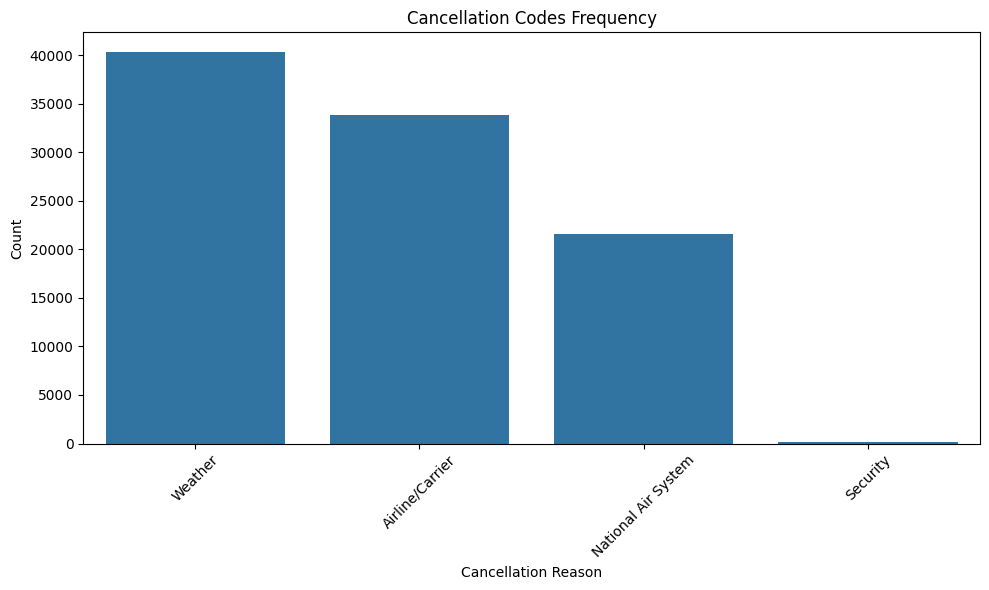

In [15]:

# Mapping dictionary for cancellation codes
cancellation_map = {
    'A': 'Airline/Carrier',
    'B': 'Weather',
    'C': 'National Air System',
    'D': 'Security'
}

# Count the occurrences of each cancellation code
cancellation_counts = df_cancel['CANCELLATION_CODE'].value_counts()

# Create a bar plot with mapped labels
plt.figure(figsize=(10, 6))
sns.barplot(
    x=cancellation_counts.index.map(cancellation_map),
    y=cancellation_counts.values
)
plt.title('Cancellation Codes Frequency')
plt.xlabel('Cancellation Reason')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can see that the most common cause for flight cancellation is the weather. By far the least cancellations are caused by security reasons.

### Breakdown of departure delays by month

Now let's take a look at average departure delay per month.

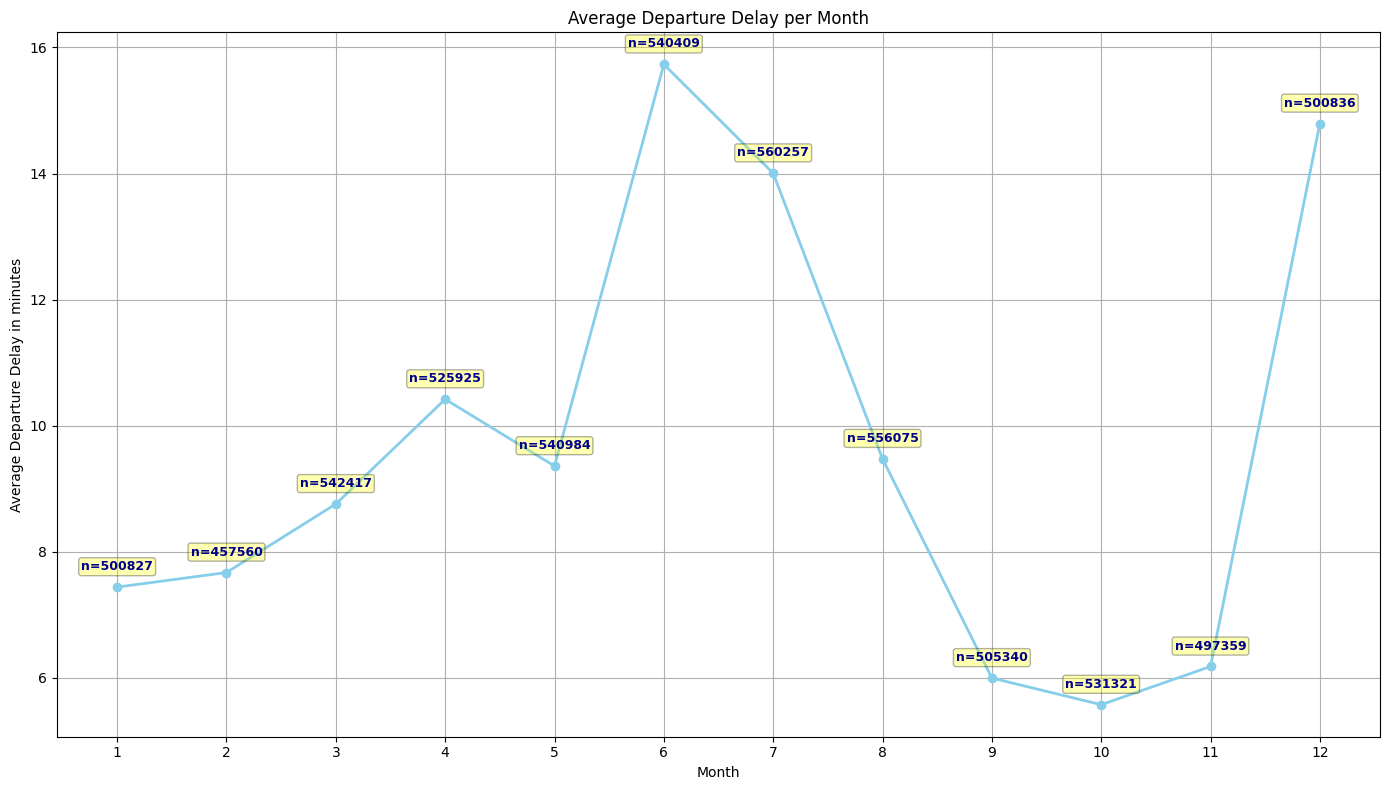

In [8]:
# Extract Year and Month from FL_DATE
#df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')
#df.loc[:, 'Year_Month'] = df['FL_DATE'].dt.to_period('M')

# Group by Year-Month and calculate the average departure delay
#monthly_delay = df.groupby('Year_Month')['DEP_DELAY'].mean()
# Calculate monthly delay
monthly_delay = df.groupby(df['MONTH'])['DEP_DELAY'].mean()

# Calculate monthly flight counts
monthly_counts = df.groupby(df['MONTH']).size()

# Plot
plt.figure(figsize=(14, 8))
line = monthly_delay.plot(kind='line', marker='o', color='skyblue', linestyle='-', linewidth=2)

# Add flight counts near each point
for month, delay in monthly_delay.items():
    count = monthly_counts[month]
    plt.annotate(f'n={count}', 
                 xy=(month, delay), 
                 xytext=(0, 10),  # 10 points vertical offset
                 textcoords='offset points',
                 ha='center', 
                 va='bottom',
                 fontweight='bold',
                 color='darkblue',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.2', 
                           fc='yellow', 
                           alpha=0.3))

plt.title('Average Departure Delay per Month')
plt.xlabel('Month')
plt.ylabel('Average Departure Delay in minutes')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.tight_layout()
plt.show()


Taking a look at the plot, we can see that the months leading up to the summer months cause bigger delay and in December the delay also spikes up. This is somewhat expected because a lot of travelling takes place in summer and December has famous holidays in which people travel to be closer to their family members (Christmas, New Year's Eve).


### Breakdown of arrival delays by month

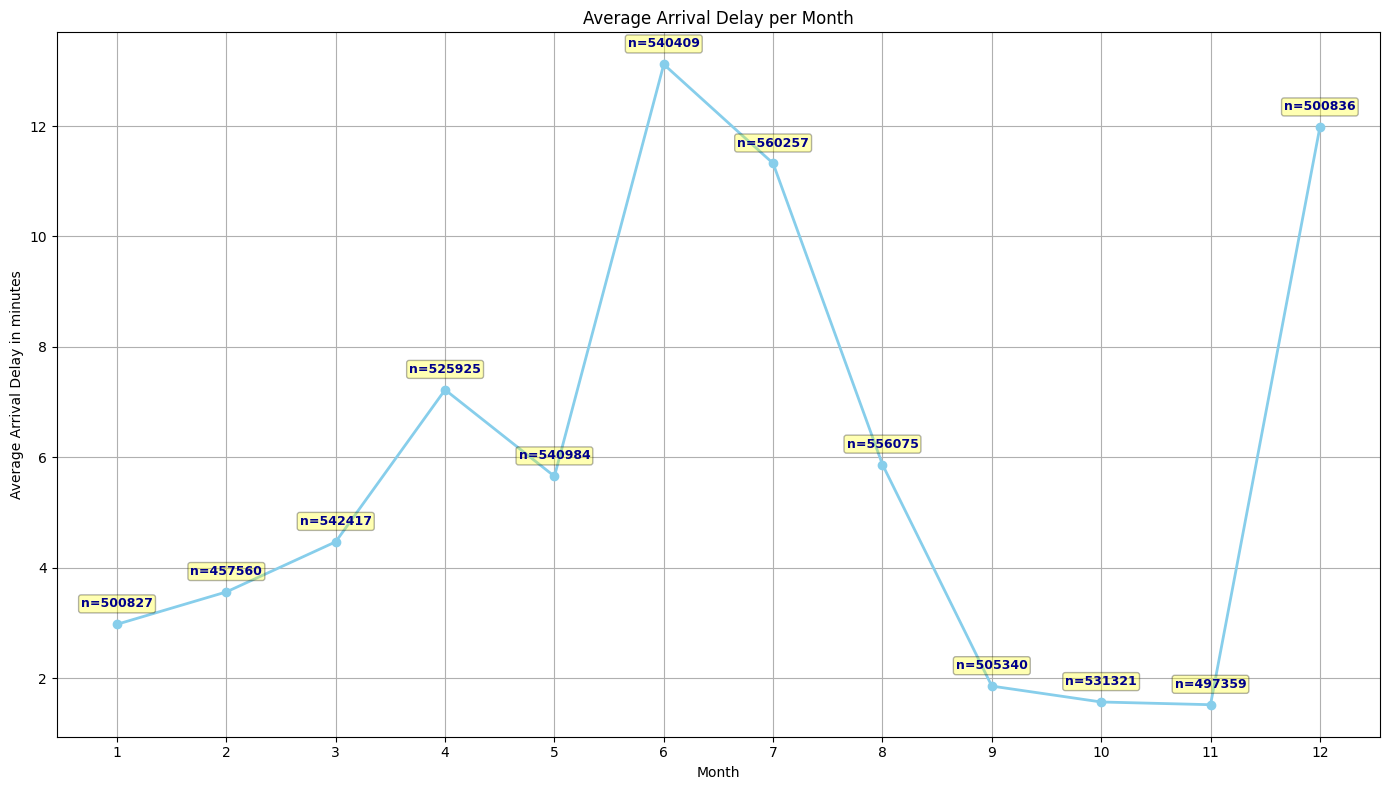

In [9]:
# Extract Year and Month from FL_DATE
#df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')
#df.loc[:, 'Year_Month'] = df['FL_DATE'].dt.to_period('M')

# Group by Year-Month and calculate the average arrival delay
#monthly_delay = df.groupby('Year_Month')['ARR_DELAY'].mean()
# Calculate monthly delay
monthly_delay = df.groupby(df['MONTH'])['ARR_DELAY'].mean()

# Calculate monthly flight counts
monthly_counts = df.groupby(df['MONTH']).size()

# Plot
plt.figure(figsize=(14, 8))
line = monthly_delay.plot(kind='line', marker='o', color='skyblue', linestyle='-', linewidth=2)

# Add flight counts near each point
for month, delay in monthly_delay.items():
    count = monthly_counts[month]
    plt.annotate(f'n={count}', 
                 xy=(month, delay), 
                 xytext=(0, 10),  # 10 points vertical offset
                 textcoords='offset points',
                 ha='center', 
                 va='bottom',
                 fontweight='bold',
                 color='darkblue',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.2', 
                           fc='yellow', 
                           alpha=0.3))

plt.title('Average Arrival Delay per Month')
plt.xlabel('Month')
plt.ylabel('Average Arrival Delay in minutes')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.tight_layout()
plt.show()


Here we can see similar trends to average departures delays. However, arrival delay is smaller than departure delay based on those graph comparisons.

### Breakdown of departure delays by weekday

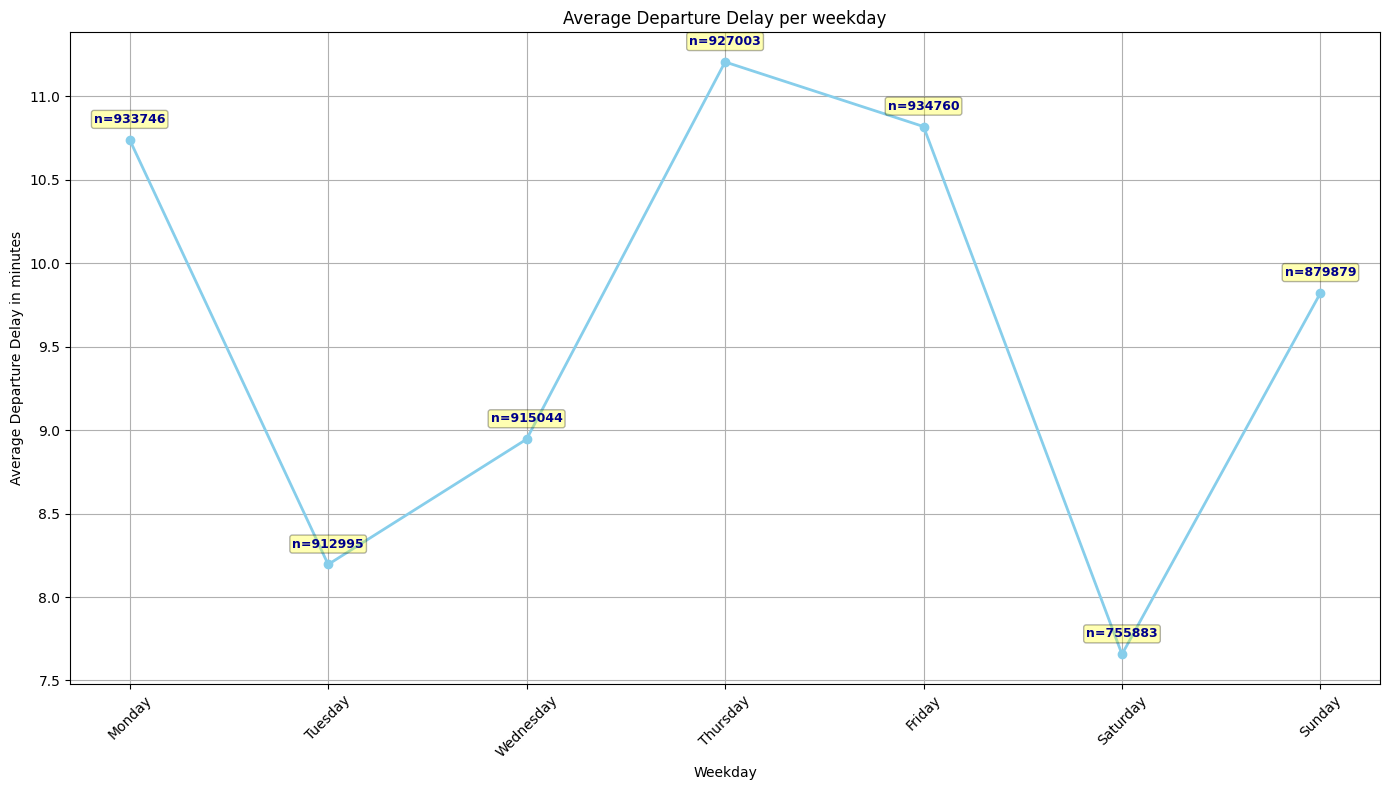

In [10]:
# Weekday mapping
week_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

weekday_delay = df.groupby(df['DAY_OF_WEEK'])['DEP_DELAY'].mean()

# Calculate monthly flight counts
weekday_counts = df.groupby(df['DAY_OF_WEEK']).size()

# Plot
plt.figure(figsize=(14, 8))
line = weekday_delay.plot(kind='line', marker='o', color='skyblue', linestyle='-', linewidth=2)

# Add flight counts near each point
for weekday, delay in weekday_delay.items():
    count = weekday_counts[weekday]
    plt.annotate(f'n={count}', 
                 xy=(weekday, delay), 
                 xytext=(0, 10),  # 10 points vertical offset
                 textcoords='offset points',
                 ha='center', 
                 va='bottom',
                 fontweight='bold',
                 color='darkblue',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.2', 
                           fc='yellow', 
                           alpha=0.3))

plt.title('Average Departure Delay per weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Departure Delay in minutes')

plt.xticks(list(week_map.keys()), [week_map[key] for key in week_map], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


From the graph we can surmize that the least common day for flights is Saturday and that the average departure delay varies from 7.7 to 11.3 minutes. The longest departure delays are on Thursdays and the shortest delays are on Saturdays.

### Breakdown of arrival delays by month

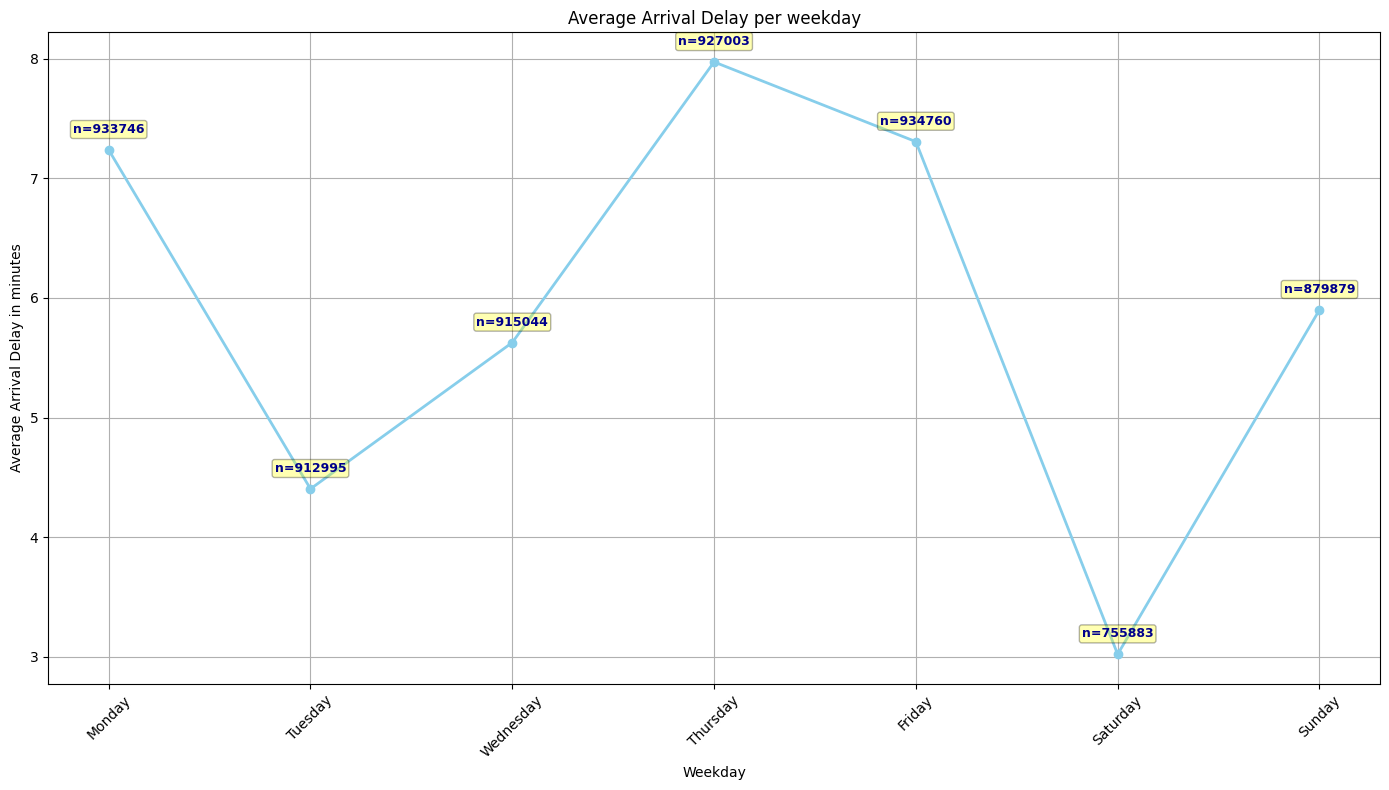

In [11]:
# Weekday mapping
week_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

weekday_delay = df.groupby(df['DAY_OF_WEEK'])['ARR_DELAY'].mean()

# Calculate monthly flight counts
weekday_counts = df.groupby(df['DAY_OF_WEEK']).size()

# Plot
plt.figure(figsize=(14, 8))
line = weekday_delay.plot(kind='line', marker='o', color='skyblue', linestyle='-', linewidth=2)

# Add flight counts near each point
for weekday, delay in weekday_delay.items():
    count = weekday_counts[weekday]
    plt.annotate(f'n={count}', 
                 xy=(weekday, delay), 
                 xytext=(0, 10),  # 10 points vertical offset
                 textcoords='offset points',
                 ha='center', 
                 va='bottom',
                 fontweight='bold',
                 color='darkblue',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.2', 
                           fc='yellow', 
                           alpha=0.3))

plt.title('Average Arrival Delay per weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Arrival Delay in minutes')

plt.xticks(list(week_map.keys()), [week_map[key] for key in week_map], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

From this graph, we can see that average arrival delays follow similar trends (at weekdays) as average departure delays. However, average arrival delays are smaller than average departure delays per weekday.

### Arrival delays by airline (carrier)

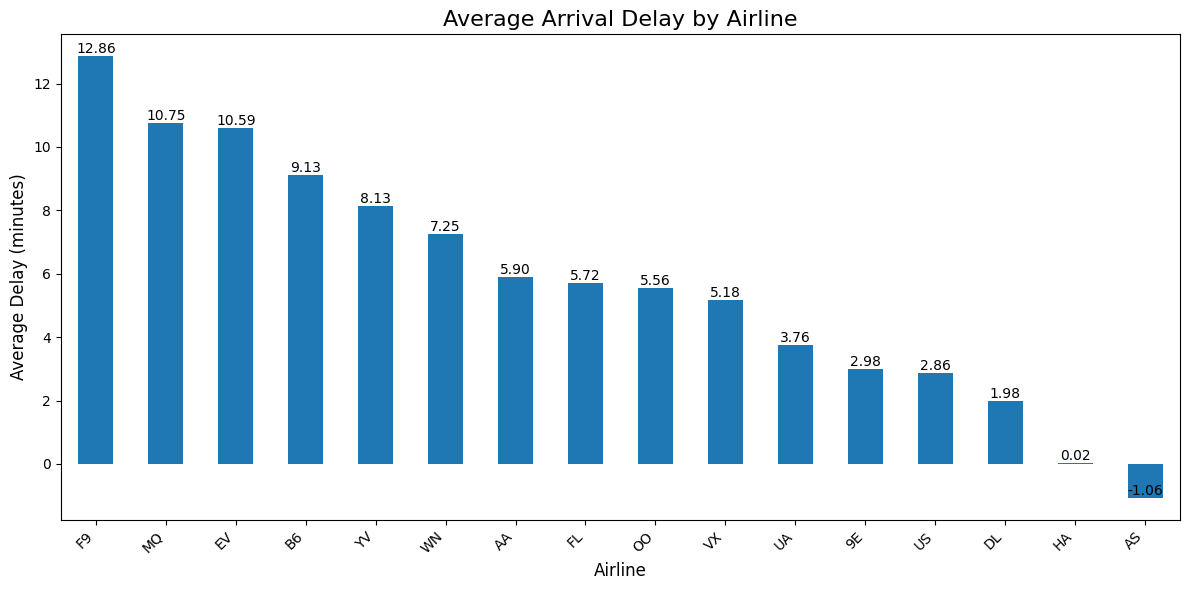

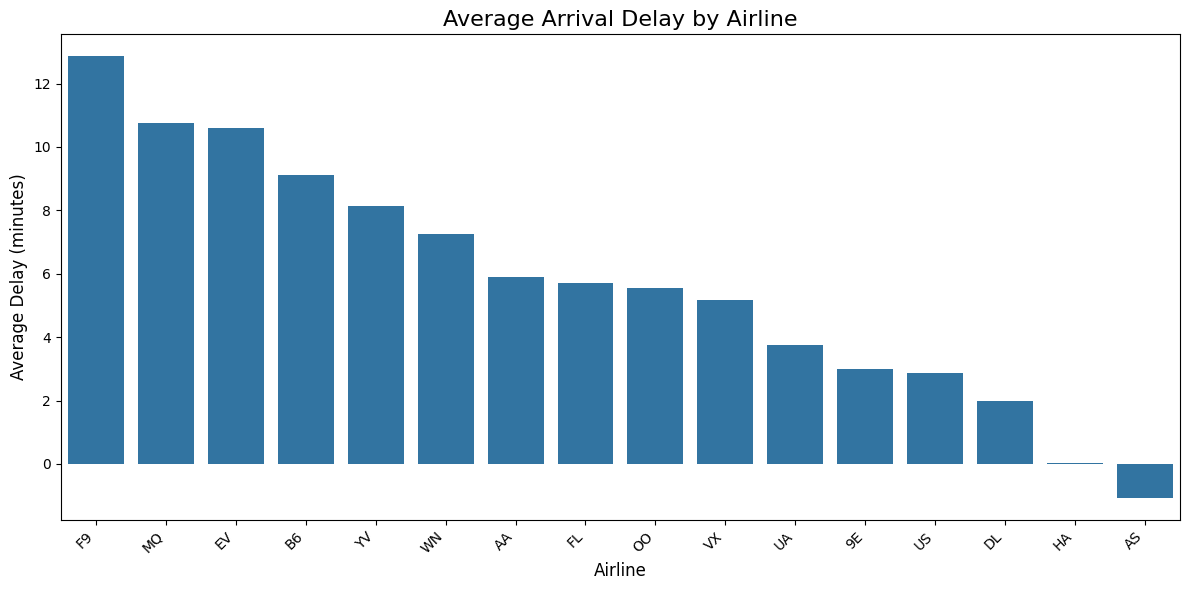

In [12]:
# Calculate average arrival delay by carrier
carrier_delays = df.groupby('OP_CARRIER')['ARR_DELAY'].mean().sort_values(ascending=False)

# Create the plot with improved styling
plt.figure(figsize=(12, 6))
carrier_delays.plot(kind='bar')
plt.title('Average Arrival Delay by Airline', fontsize=16)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Optional: Add value labels on top of each bar
for i, v in enumerate(carrier_delays):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

# Alternative with Seaborn for more styling options
plt.figure(figsize=(12, 6))
sns.barplot(x=carrier_delays.index, y=carrier_delays.values)
plt.title('Average Arrival Delay by Airline', fontsize=16)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From this graph, we can conclude that the highest delays are on Mondays, Thursdays, and Sundays. Thursdays also had the most flights (194954).

### Analysing different routes

**!NB this analysis is mostly done in the data processing part as well. It has been added here for the sake of consistency.**

Route Delay Metrics Summary:
Total Routes Analyzed: 4706
Routes with 10+ Flights: 4570

Delay Statistics:
       MEAN_ROUTE_DELAY  MEDIAN_ROUTE_DELAY  MAX_ROUTE_DELAY  \
count       4706.000000         4706.000000      4706.000000   
mean           5.898809           -3.174989       374.364853   
std           10.009018            9.157573       244.439049   
min          -35.000000          -37.000000       -35.000000   
25%            1.283925           -6.000000       233.000000   
50%            5.377321           -4.000000       322.500000   
75%            9.633999           -1.000000       439.000000   
max          315.000000          315.000000      1983.000000   

       ROUTE_DELAY_SEVERITY  
count           4570.000000  
mean              32.098575  
std               10.398393  
min                4.000000  
25%               25.068812  
50%               30.595623  
75%               37.669508  
max              114.945455  

Top 10 Routes by Delay Severity:
     ORIGIN D

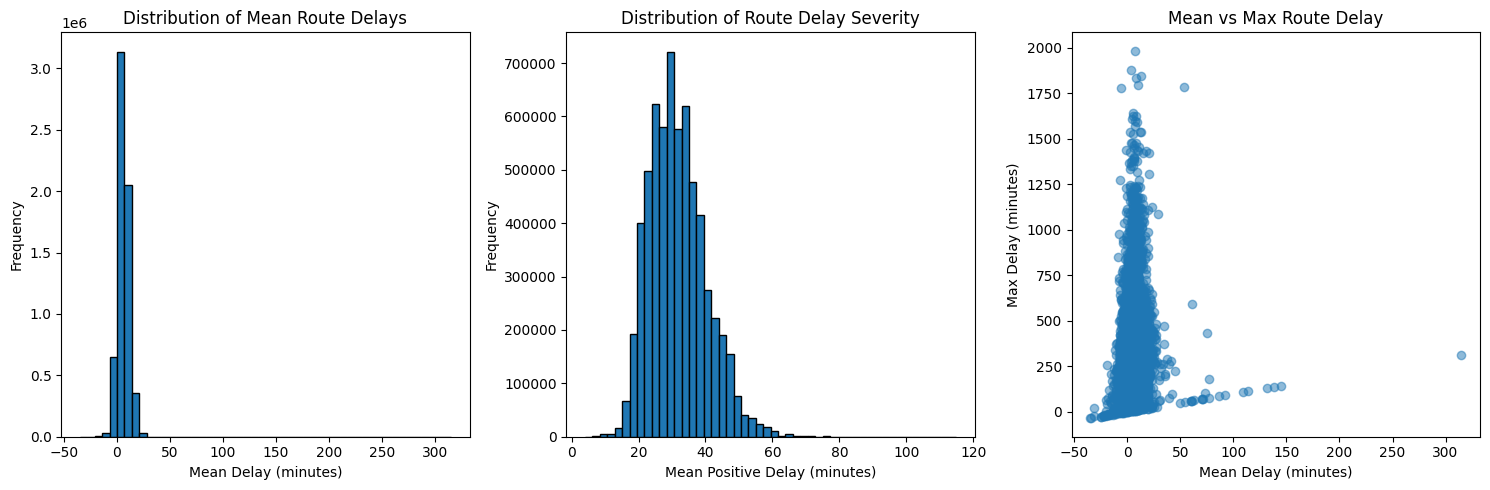

Top 10 Most Delayed (Arrival Delay) Routes by Mean Delay:
     ORIGIN DEST  mean_delay  median_delay  max_delay  total_delay_minutes  \
3212    MSY  GPT       315.0         315.0        315                  315   
3775    PIT  RIC       145.0         145.0        145                  145   
2534    LFT  AEX       138.0         138.0        138                  138   
3065    MSN  SFO       132.0         132.0        132                  132   
413     BNA  BTV       114.0         114.0        114                  114   
4043    SAT  GRK       109.0         109.0        109                  109   
3893    RIC  BWI        92.0          92.0         92                   92   
4533    SWF  ATL        86.0          86.0         86                   86   
259     ATL  SWF        77.0          77.0         77                   77   
2206    JAC  EWR        76.5          59.5        179                 1530   

      delay_severity  total_flights  
3212           315.0              1  
3775   

In [13]:
def add_historical_route_delay_severity(flights_df, min_flights=10):
    """
    Calculate route delay severity based on actual delay minutes
    
    Parameters:
    - flights_df: Input dataframe
    - min_flights: Minimum number of flights for a route to be considered
    """
    # Calculate route delay statistics
    route_delay_stats = flights_df.groupby(['ORIGIN', 'DEST']).agg({
        'ARR_DELAY': [
            ('mean_delay', 'mean'),           # Average delay for the route
            ('median_delay', 'median'),        # Median delay for the route
            ('max_delay', 'max'),              # Maximum delay for the route
            ('total_delay_minutes', 'sum'),    # Total delay minutes
            ('delay_severity', lambda x: np.mean(np.abs(x[x > 0]))),  # Mean of positive delays
            ('total_flights', 'count')         # Total number of flights
        ]
    }).reset_index()

    # Flatten multi-level column names
    route_delay_stats.columns = [
        'ORIGIN', 'DEST', 
        'MEAN_ROUTE_DELAY', 'MEDIAN_ROUTE_DELAY', 'MAX_ROUTE_DELAY', 
        'TOTAL_ROUTE_DELAY_MINUTES', 'MEAN_POSITIVE_DELAY', 'TOTAL_FLIGHTS'
    ]

    # Calculate delay severity metrics for routes with sufficient data
    route_delay_stats['ROUTE_DELAY_SEVERITY'] = np.where(
        route_delay_stats['TOTAL_FLIGHTS'] >= min_flights,
        route_delay_stats['MEAN_POSITIVE_DELAY'],
        np.nan
    )

    # Merge the route delay metrics back to the original dataframe
    flights_with_delay_metrics = flights_df.merge(
        route_delay_stats[[
            'ORIGIN', 'DEST', 
            'MEAN_ROUTE_DELAY', 
            'MEDIAN_ROUTE_DELAY', 
            'MAX_ROUTE_DELAY', 
            'ROUTE_DELAY_SEVERITY'
        ]],
        on=['ORIGIN', 'DEST'],
        how='left'
    )

    # Fill NaN with overall mean metrics
    overall_mean_delay = route_delay_stats['MEAN_ROUTE_DELAY'].mean()
    overall_delay_severity = route_delay_stats['ROUTE_DELAY_SEVERITY'].mean()
    
    flights_with_delay_metrics['MEAN_ROUTE_DELAY'].fillna(overall_mean_delay, inplace=True)
    flights_with_delay_metrics['ROUTE_DELAY_SEVERITY'].fillna(overall_delay_severity, inplace=True)

    # Print comprehensive statistics
    print("Route Delay Metrics Summary:")
    print(f"Total Routes Analyzed: {len(route_delay_stats)}")
    print(f"Routes with {min_flights}+ Flights: {len(route_delay_stats[route_delay_stats['TOTAL_FLIGHTS'] >= min_flights])}")
    
    print("\nDelay Statistics:")
    print(route_delay_stats[['MEAN_ROUTE_DELAY', 'MEDIAN_ROUTE_DELAY', 'MAX_ROUTE_DELAY', 'ROUTE_DELAY_SEVERITY']].describe())

    # Top 10 routes by delay severity
    print("\nTop 10 Routes by Delay Severity:")
    top_routes = route_delay_stats[route_delay_stats['TOTAL_FLIGHTS'] >= min_flights].sort_values(
        'ROUTE_DELAY_SEVERITY', 
        ascending=False
    ).head(10)
    print(top_routes)

    # Visualization
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))
    
    # Subplot 1: Mean Route Delay Distribution
    plt.subplot(1, 3, 1)
    plt.hist(
        flights_with_delay_metrics['MEAN_ROUTE_DELAY'].dropna(),
        bins=50,
        edgecolor='black'
    )
    plt.title('Distribution of Mean Route Delays')
    plt.xlabel('Mean Delay (minutes)')
    plt.ylabel('Frequency')

    # Subplot 2: Route Delay Severity Distribution
    plt.subplot(1, 3, 2)
    plt.hist(
        flights_with_delay_metrics['ROUTE_DELAY_SEVERITY'].dropna(),
        bins=50,
        edgecolor='black'
    )
    plt.title('Distribution of Route Delay Severity')
    plt.xlabel('Mean Positive Delay (minutes)')
    plt.ylabel('Frequency')

    # Subplot 3: Scatter of Mean Delay vs Max Delay
    plt.subplot(1, 3, 3)
    plt.scatter(
        route_delay_stats['MEAN_ROUTE_DELAY'], 
        route_delay_stats['MAX_ROUTE_DELAY'],
        alpha=0.5
    )
    plt.title('Mean vs Max Route Delay')
    plt.xlabel('Mean Delay (minutes)')
    plt.ylabel('Max Delay (minutes)')

    plt.tight_layout()
    plt.show()

    return flights_with_delay_metrics

# Apply the function
combined_flights_with_delay_metrics = add_historical_route_delay_severity(
    df, 
    min_flights=10  # Routes with at least 10 flights
)# Calculate route delay statistics
route_delay_stats = df.groupby(['ORIGIN', 'DEST']).agg({
    'ARR_DELAY': [
        ('mean_delay', 'mean'),           # Average delay for the route
        ('median_delay', 'median'),       # Median delay for the route
        ('max_delay', 'max'),             # Maximum delay for the route
        ('total_delay_minutes', 'sum'),   # Total delay minutes
        ('delay_severity', lambda x: np.mean(x[x > 0]) if len(x[x > 0]) > 0 else 0),  # Mean of positive delays
        ('total_flights', 'count')        # Total number of flights
    ]
}).reset_index()

# Flatten column names for readability
route_delay_stats.columns = ['ORIGIN', 'DEST', 'mean_delay', 'median_delay', 'max_delay', 
                             'total_delay_minutes', 'delay_severity', 'total_flights']

# Find the top 10 routes with the highest mean delay
most_delayed_routes = route_delay_stats.sort_values(by='mean_delay', ascending=False).head(10)

# Display results
print("Top 10 Most Delayed (Arrival Delay) Routes by Mean Delay:")
print(most_delayed_routes)

From this output, we can see that the most delayed routes by average delay are the flights that only have had 1 flight in the year. Let's check for routes that have had at least 20 flights in 2013.

In [14]:
# Filter routes with at least 20 total flights
filtered_routes = route_delay_stats[route_delay_stats['total_flights'] >= 20]

# Find the top 10 routes with the highest mean delay after filtering
most_delayed_routes = filtered_routes.sort_values(by='mean_delay', ascending=False).head(10)

print("Top 10 Most Delayed Routes by Mean Delay (At Least 20 Flights):")
print(most_delayed_routes)

Top 10 Most Delayed Routes by Mean Delay (At Least 20 Flights):
     ORIGIN DEST  mean_delay  median_delay  max_delay  total_delay_minutes  \
2206    JAC  EWR   76.500000          59.5        179                 1530   
3071    MSO  SFO   75.345455          61.0        435                 4144   
655     BZN  EWR   61.400000          31.0        590                 2149   
3789    PPG  HNL   53.773585           1.0       1783                 5700   
1555    EWR  CAE   44.585106          31.0        224                 4191   
1625    EWR  TYS   41.150160          14.0        281                12880   
1715    FLL  TTN   38.871560          22.0        263                 4237   
1997    IAD  PNS   37.308511           9.0        290                 3507   
3254    OAK  BOS   35.375000          21.5        209                 2830   
1802    GSO  MCO   35.000000          14.5        474                 1820   

      delay_severity  total_flights  
2206       76.500000             20  
3

Some routes with over 20 flights still have a very high average delay, even surpassing a whole hour.